In [1]:
from UctZone import UctZone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import seaborn as sns
%config InlineBackend.figure_format='retina'
# plt.style.use('dark_background')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Change this to test different parameters
alpha = 0.05
eta = 0.05

day = 1  # How many days to simulate (8 hours a day)
K = 100 # Strike price
n = int(3600 * 8 * 10 * day)
sigma_ann = 0.2
sigma = sigma_ann / np.sqrt(252 / day)
r_ann = 0.05
r = r_ann / (360 / day)

beta = 1  # CEV
A = UctZone(alpha, eta)  # for clearer plot set alpha=0.5
A.get_eff_price_CEV(n, sigma, r=r, beta=beta)  # Daily drift and volatility
A.get_exit_times(L_mode="naive")
A.get_obs_price(jump_mode="beta")

Text(0.5, 1.0, 'L_mode=naive, jump_mode=beta, 1 day, every 1/10 sec')

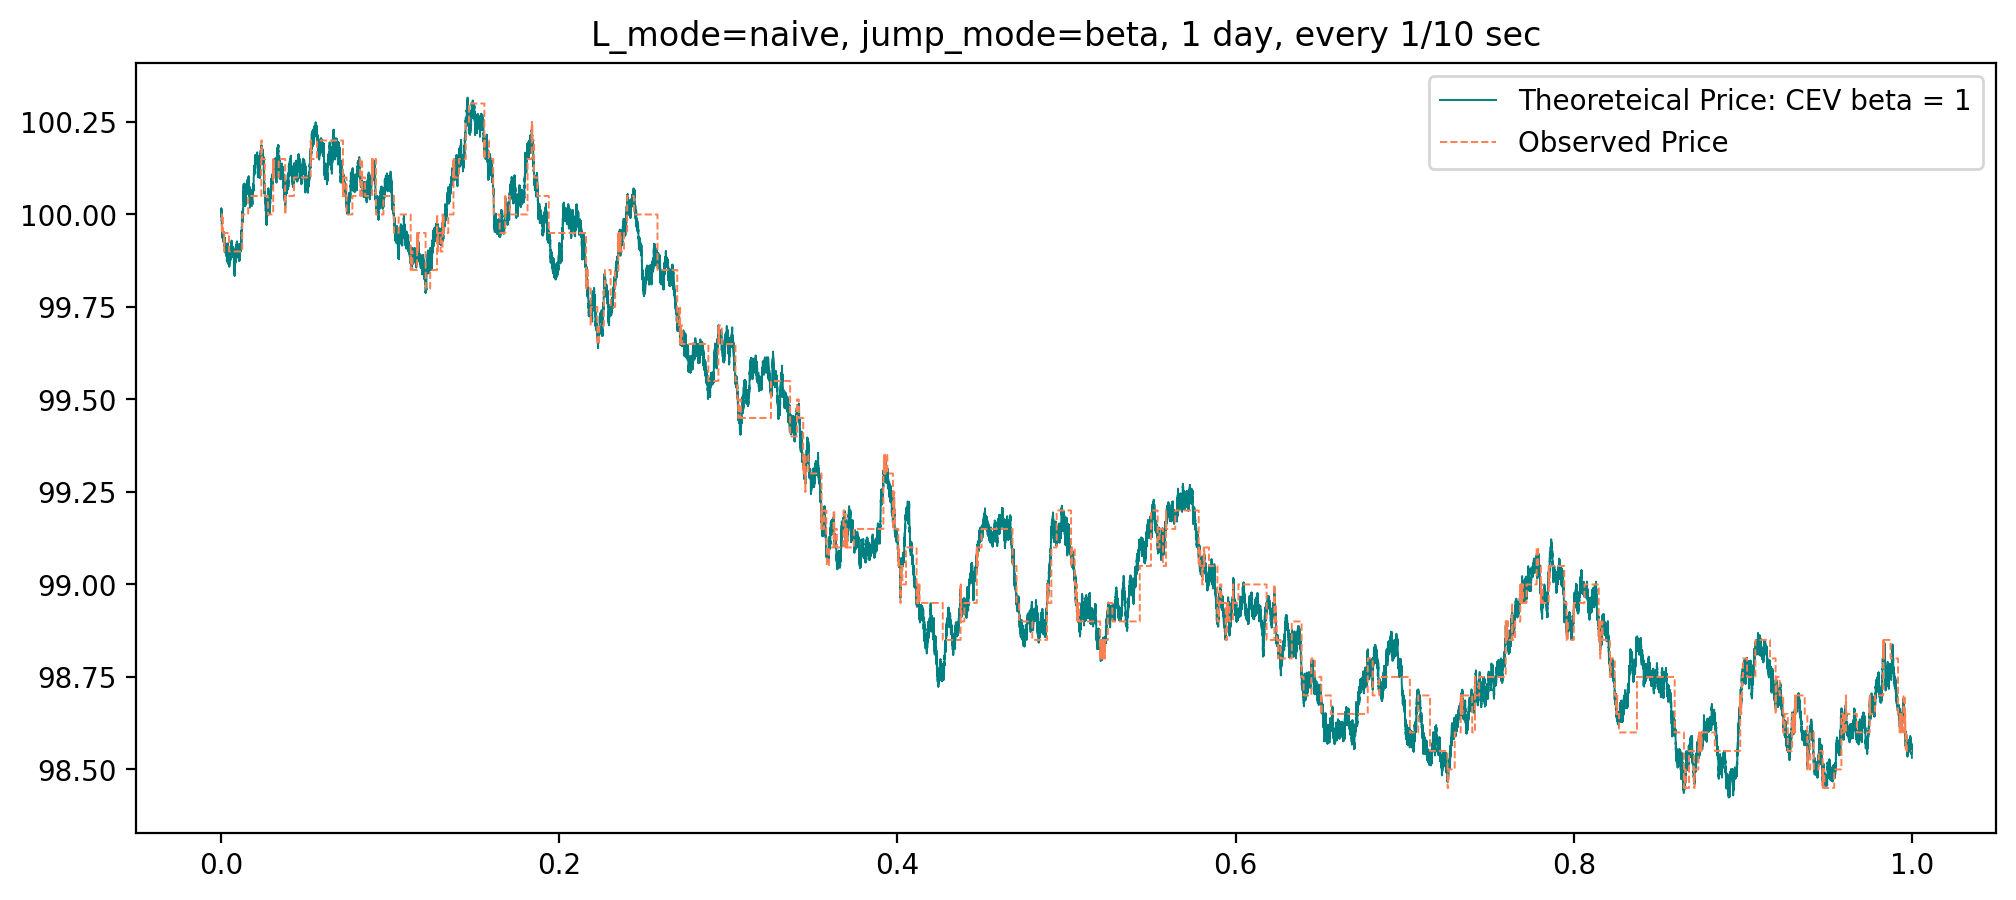

In [3]:
fig, ax = plt.subplots(figsize=(12, 5))
pd.Series(index=A.t, data=A.x).plot(
    lw=0.7, color='teal', ax=ax, label="Theoreteical Price: CEV beta = " + str(beta))  # Theoretical price
ax.step(A.t, A.p, '--',where='post', 
        color='coral', lw=0.7, label="Observed Price")  # Observed price
ax.legend()
plt.title("L_mode=naive, jump_mode=beta, 1 day, every 1/10 sec")

I need:
- list of stopping times index: A.tau
- list of observed price: A.obs_price
- benchmark price at final and start

In [4]:
def BSCall(S0, K, sigma, T, r):
    '''
    Inputs:
    S0: initial stock price
    K: strike price
    sigma: volatility of the stock's return
    T: time to maturity (e.g., T=1 for one year)
    r: risk-free interest rate
    
    Output:
    Black-Scholes Call price
    '''
    sigT = sigma * np.sqrt(T)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / sigT
    d2 = d1 - sigT
    
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def delta(S, K, sigma, T, r):
    """
    Calculate the delta of a call option
    S: current stock price
    K: strike price
    sigma: volatility of the stock's return
    T: time to maturity
    r: risk-free interest rate
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)


## Simulate hedging portfolio

In [5]:
alpha = 0.05
eta = 0.05

day = 1  # How many days to simulate (8 hours a day)
K = 100 # Strike price
n = int(3600 * 8 * 10 * day)
sigma_ann = 0.2
sigma = sigma_ann / np.sqrt(252 / day)
r_ann = 0.05
r = r_ann / (360 / day)

beta = 1  # CEV
A = UctZone(alpha, eta)  # for clearer plot set alpha=0.5
A.get_eff_price_CEV(n, sigma, r=r, beta=beta)  # Daily drift and volatility
A.get_exit_times(L_mode="naive")
A.get_obs_price(jump_mode="beta")

In [68]:
T = A.T
t = A.t
x = A.x
p = A.p
tau = A.tau
portfolio_value_2 = np.zeros(len(tau)) # benchmark hedging portfolio value
hedging_position_2 = np.zeros(len(tau)) # hedging position dC/dS
call_option_price_2 = np.zeros(len(tau)) # call option price

# given the stopping time tau, we can calculate the hedging position and portfolio value
call_option_price_2[0] = BSCall(x[0], K, sigma, T - t[0],r)
portfolio_value_2[0] = call_option_price_2[0]
hedging_position_2[0] = delta(x[0], K, sigma, T - t[0],r) # calculate delta still using efficient price x

for i in tqdm(range(1, len(tau)),colour='green'):
    dT = T - t[tau[i]] # Remaining time to maturity
    # Update the portfolio value for changes in the option price and underlying asset
    portfolio_value_2[i] = portfolio_value_2[i-1] + hedging_position_2[i-1] * (p[tau[i]] - p[tau[i-1]])
    # Re-hedge the portfolio by adjusting the position in the underlying
    hedging_position_2[i] = delta(x[tau[i]], K, sigma, dT, r)
    # compute the call option price
    call_option_price_2[i] = BSCall(x[tau[i]], K, sigma, dT, r)

100%|██████████| 484/484 [00:00<00:00, 11194.93it/s]


End of day hedging error: -0.4275204768784253


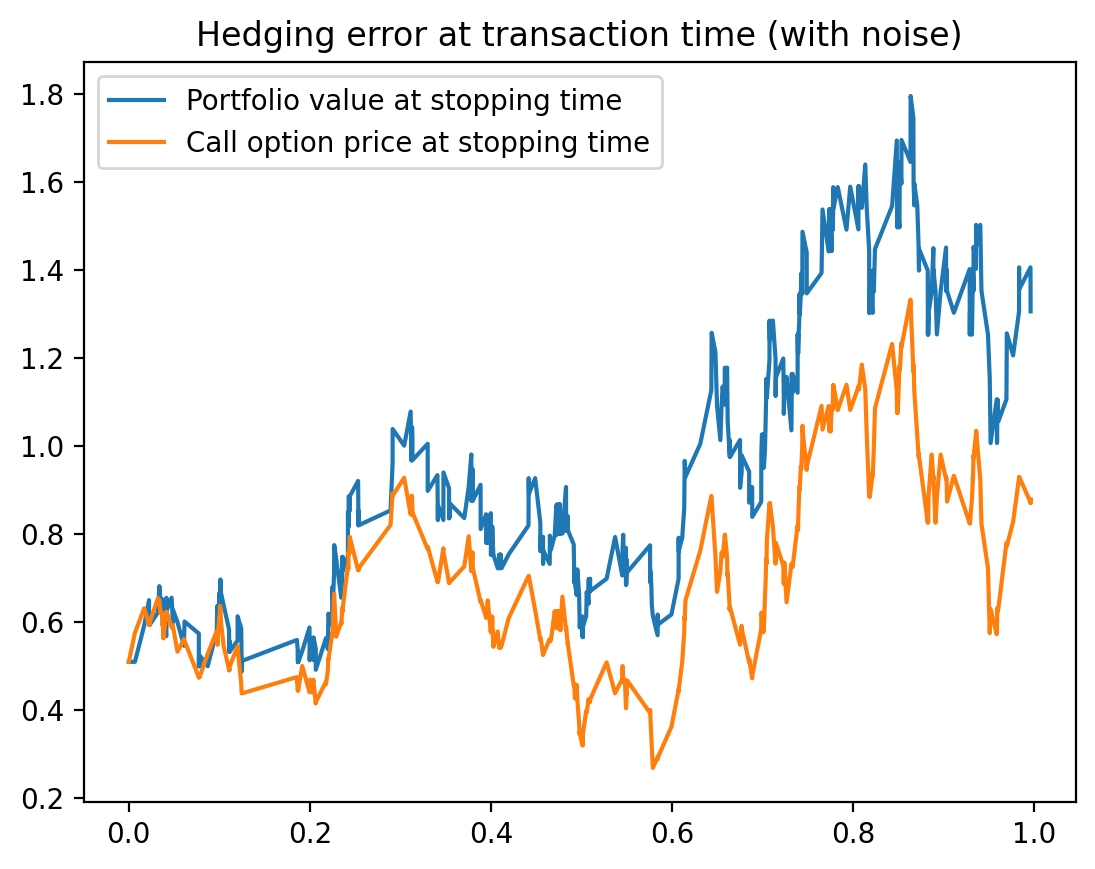

In [69]:
print(f"End of day hedging error: {call_option_price_2[-1]-portfolio_value_2[-1]}")
# plot the hedging error
plt.plot(t[tau], portfolio_value_2, label = 'Portfolio value at stopping time')
plt.plot(t[tau], call_option_price_2, label = 'Call option price at stopping time')
plt.legend()
plt.title("Hedging error at transaction time (with noise)")
plt.show()

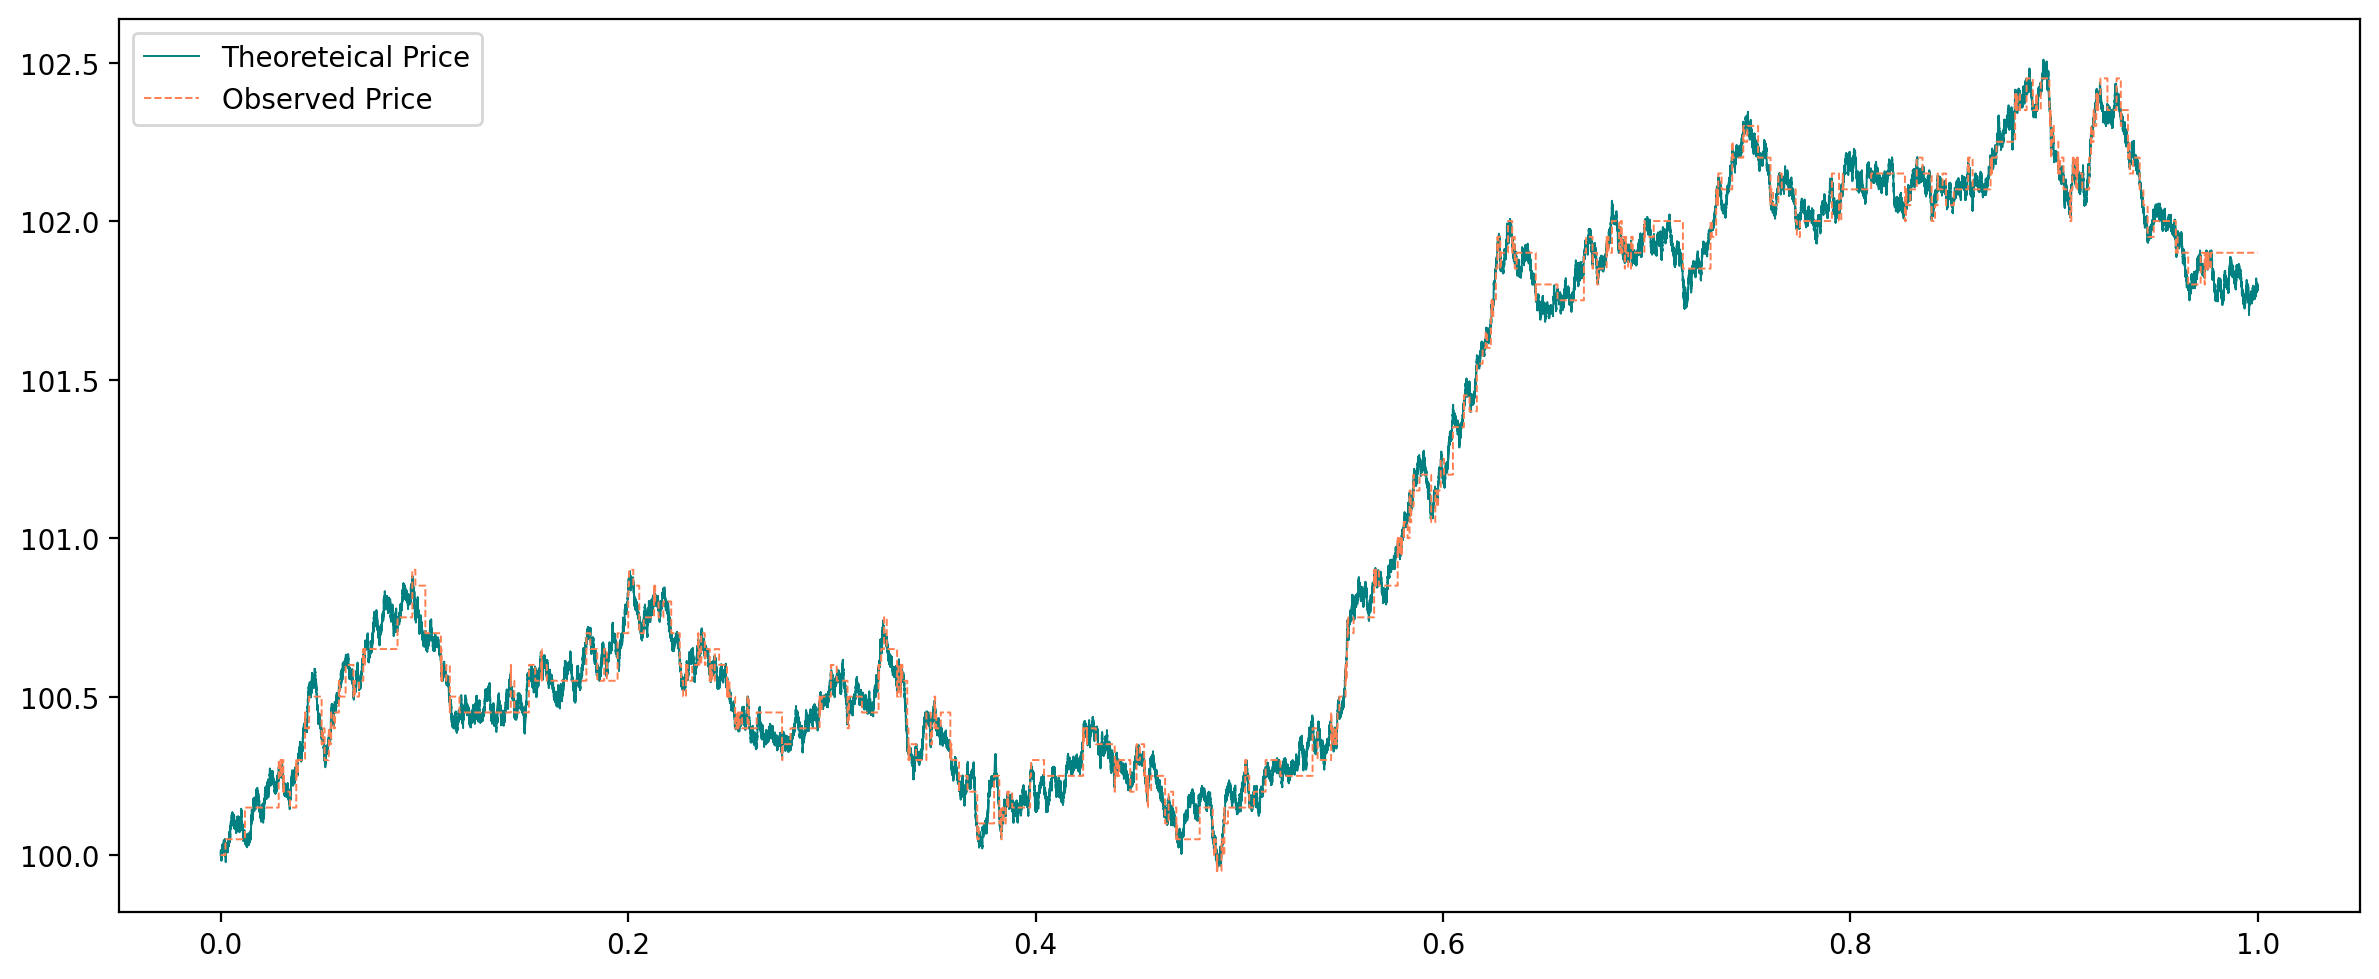

In [20]:
A.plot()
tau_new = [0]
k = int(A.x[0] / A.alpha)
last_obs = k * A.alpha
l = A.alpha ** (-0.5)

i = 0
while i < len(A.x):
    if A.x[i] > last_obs + A.alpha * (l - 0.5 + A.eta):
        tau_new.append(i)
        last_obs = (A.x[i] // A.alpha) * A.alpha
    elif A.x[i] < last_obs - A.alpha * (l - 0.5 + A.eta):
        tau_new.append(i)
        last_obs = (A.x[i] // A.alpha) * A.alpha
    i += 1

In [24]:
T = A.T
t = A.t
x = A.x
p = A.p
tau = tau_new

In [25]:
portfolio_value_3 = np.zeros(len(tau)) # benchmark hedging portfolio value
hedging_position_3 = np.zeros(len(tau)) # hedging position dC/dS
call_option_price_3 = np.zeros(len(tau)) # call option price

# given the stopping time tau, we can calculate the hedging position and portfolio value
call_option_price_3[0] = BSCall(x[0], K, sigma, T - t[0], r)
portfolio_value_3[0] = call_option_price_3[0]
hedging_position_3[0] = delta(x[0], K, sigma, T - t[0], r) # calculate delta still using efficient price x

for i in tqdm(range(1, len(tau)),colour='green'):
    dT = T - t[tau[i]] # Remaining time to maturity
    # Update the portfolio value for changes in the option price and underlying asset
    portfolio_value_3[i] = portfolio_value_3[i-1] + hedging_position_3[i-1] * (p[tau[i]] - p[tau[i-1]])
    # Re-hedge the portfolio by adjusting the position in the underlying
    hedging_position_3[i] = delta(x[tau[i]], K, sigma, dT, r)
    # compute the call option price
    call_option_price_3[i] = BSCall(x[tau[i]], K, sigma, dT, r)


100%|██████████| 36/36 [00:00<00:00, 3216.01it/s]


End of day hedging error: -0.17343690787260257


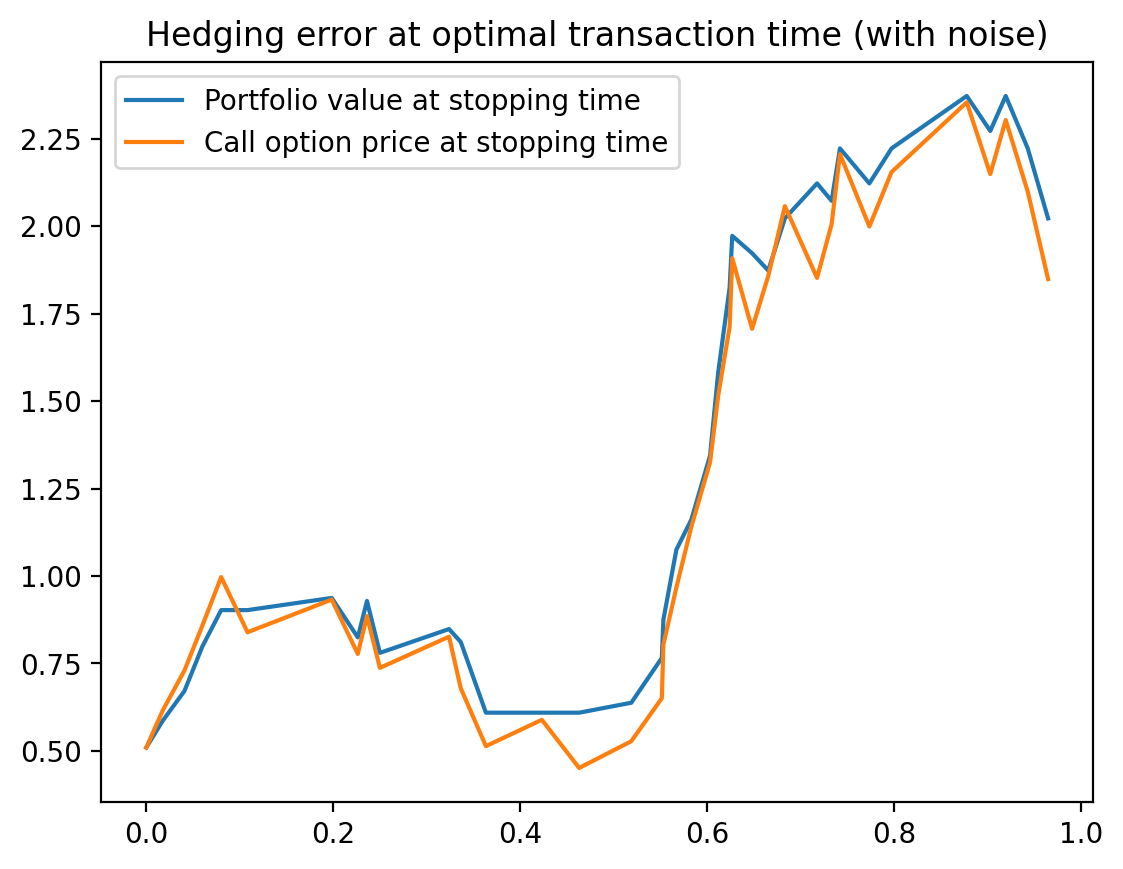

In [26]:
print(f"End of day hedging error: {call_option_price_3[-1]-portfolio_value_3[-1]}")
# plot the hedging error
plt.plot(t[tau], portfolio_value_3, label = 'Portfolio value at stopping time')
plt.plot(t[tau], call_option_price_3, label = 'Call option price at stopping time')
plt.legend()
plt.title("Hedging error at optimal transaction time (with noise)")
plt.show()

## Monte Carlo

In [27]:
l_alpha = np.round(alpha**(-1/2))
beta = 1  # CEV
sigma = 0.01

In [32]:
# simulate the efficient price path
number_of_paths = 100
error_1 = np.zeros(number_of_paths) # uncertainty zone without noise
error_2 = np.zeros(number_of_paths) # uncertainty zone with noise
error_3 = np.zeros(number_of_paths) # optimal uncertainty zone with noise
A = UctZone(alpha, eta)
for i in tqdm(range(number_of_paths),colour='green',desc='calcualte hedging error'):
    A.get_eff_price_CEV(n, sigma, r=r, beta=beta) # simulate the efficient price path
    A.get_exit_times(L_mode="naive")
    A.get_obs_price(jump_mode="beta")
    T = A.T
    t = A.t
    x = A.x
    p = A.p # observed price
    tau = A.tau # stopping time
    portfolio_value_1 = np.zeros(len(tau)) # hedging portfolio value without noise
    portfolio_value_2 = np.zeros(len(tau)) # hedging portfolio value with noise, hedge for every price change
    hedging_position = np.zeros(len(tau))
    call_option_price = np.zeros(len(tau)) # call option price
    # given the stopping time tau, we can calculate the hedging position and portfolio value
    call_option_price[0] = BSCall(x[0], K, sigma, T - t[0], r)
    portfolio_value_1[0] = call_option_price[0]
    portfolio_value_2[0] = call_option_price[0]
    hedging_position[0] = delta(x[0], K, sigma, T - t[0], r) # calculate delta still using efficient price x
    for j in range(1, len(tau)):
        dT = T - t[tau[j]] # Remaining time to maturity
        # Update the portfolio value for changes in the option price and underlying asset
        portfolio_value_1[j] = portfolio_value_1[j-1] + hedging_position[j-1] * (x[tau[j]] - x[tau[j-1]])
        portfolio_value_2[j] = portfolio_value_2[j-1] + hedging_position[j-1] * (p[tau[j]] - p[tau[j-1]])
        hedging_position[j] = delta(x[tau[j]], K, sigma, dT, r)
    call_option_price_final = x[-1] - K if x[-1] > K else 0 # maturity call option price
    error_1[i] = call_option_price_final - portfolio_value_1[-1]
    error_2[i] = call_option_price_final - portfolio_value_2[-1]

    # # simulate for optimal hedge
    # A.alpha = l_alpha*alpha # based on optimal l
    # # refresh the oberverd price and exit time while fixing the efficient price path
    # A.get_exit_times(L_mode="naive")
    # A.get_obs_price(jump_mode="beta")
    # p = A.p
    # tau = A.tau
    ############################################
    tau_new = [0]
    k = int(A.x[0] / A.alpha)
    last_obs = k * A.alpha
    l = A.alpha ** (-0.5)

    ii = 0
    while ii < len(A.x):
        if A.x[ii] > last_obs + A.alpha * (l - 0.5 + A.eta):
            tau_new.append(ii)
            last_obs = (A.x[ii] // A.alpha) * A.alpha
        elif A.x[ii] < last_obs - A.alpha * (l - 0.5 + A.eta):
            tau_new.append(ii)
            last_obs = (A.x[ii] // A.alpha) * A.alpha
        ii += 1

    tau = tau_new
    ############################################
    portfolio_value_3 = np.zeros(len(tau)) # hedging portfolio value with noise, hedge for every price change
    portfolio_value_3[0] = call_option_price[0]
    hedging_position_3 = np.zeros(len(tau))
    for j in range(1, len(tau)):
        dT = T - t[tau[j]]
        portfolio_value_3[j] = portfolio_value_3[j-1] + hedging_position_3[j-1] * (p[tau[j]] - p[tau[j-1]])
        hedging_position_3[j] = delta(x[tau[j]], K, sigma, dT, r)
    error_3[i] = call_option_price_final - portfolio_value_3[-1]

        

calcualte hedging error: 100%|██████████| 100/100 [04:20<00:00,  2.60s/it]


/opt/anaconda3/envs/mf_coding/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/mf_coding/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/mf_coding/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


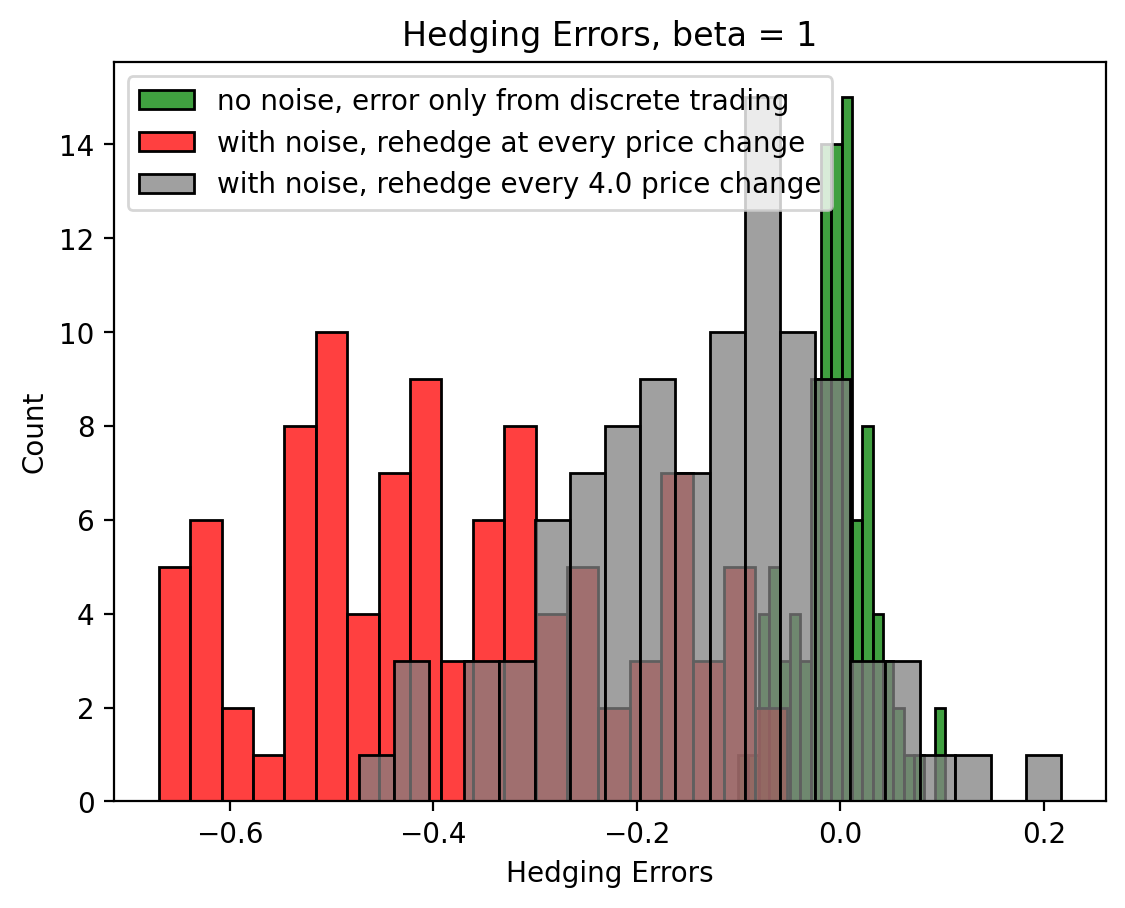

In [33]:
sns.histplot(error_1, label = "no noise, error only from discrete trading", bins = 20, color = 'green')
sns.histplot(error_2, label = "with noise, rehedge at every price change", bins = 20, color = 'red')
sns.histplot(error_3, label = f"with noise, rehedge every {l_alpha} price change", bins = 20, color='grey')
plt.xlabel("Hedging Errors")
plt.title("Hedging Errors, beta = 1")
plt.legend()